# Temperature Anomaly Forecasting for Caribbean Region using XGBoost

In this section, we will use the famous XGBoost (Extreme Gradient Boosting) ML Methos for predicting temperature anomalies for the month or a year. XGBoost is a powerful tree-based method. Although it is not designed specifically for time series data, we can engineer temporal and seasonal features to make it work. Therefore, feature engineering is very important.

In [50]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
#First, let's import out dataset

# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

## Create time features

XGBoost needs to have time features for the best model. During our EDA, we added the following features to the original dataframe:

- Rolling statistics: temp_3m(6m, 12m), std_10y
- Lag features

The following needs to be added to point out to the model that temperature anomaly is a time series data.

- Trend features
- Time-based years since start

In [3]:
df.columns

Index(['temp_anomaly', 'precip', 'year', 'month', 'temp_3m', 'temp_6m',
       'temp_12m', 'temp_10y', 'temp_rolling_std', 'season', 'rainy_month',
       'decade', 'precip_log', 'rain_3m', 'rain_6m', 'rain_12m', 'rain_10y',
       'rain_rolling_std', 'temp_anomaly_z', 'precip_log_z', 'temp_trend',
       'precip_trend_log', 'precip_trend', 'temp_trend_lag1',
       'precip_trend_log_lag1', 'precip_trend_log_lag2'],
      dtype='object')

In [7]:
df_t = df[['temp_anomaly']].copy()
df_t.head()

,temp_anomaly
date,
1980-01-01,0.29
1980-02-01,0.31
1980-03-01,0.28
1980-04-01,0.29
1980-05-01,0.35


In [12]:

#Lag features
df_t['temp_lag1'] = df_t['temp_anomaly'].shift(1)
df_t['temp_lag2'] = df_t['temp_anomaly'].shift(2)

#Rolling statistics
df_t['temp_rolling_mean_4y'] = df_t['temp_anomaly'].rolling(48).mean()
df_t['temp_rolling_std_4y'] = df_t['temp_anomaly'].rolling(48).mean()


# Trend features
df_t['temp_diff1'] = df_t['temp_anomaly'].diff(1)
df_t['temp_diff2'] = df_t['temp_anomaly'].diff(2)

#Time-based
df_t['years-since-start'] = df['year'] - df['year'].min()

In [13]:
df_t.head()

,temp_anomaly,temp_lag1,temp_lag2,temp_rolling_mean_4y,temp_rolling_std_4y,temp_dif1,temp_dif2,years-since-start,temp_diff1,temp_diff2
date,,,,,,,,,,
1980-01-01,0.29,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1980-02-01,0.31,0.29,NaN,NaN,NaN,0.02,NaN,0,0.02,NaN
1980-03-01,0.28,0.31,0.29,NaN,NaN,-0.03,-0.01,0,-0.03,-0.01
1980-04-01,0.29,0.28,0.31,NaN,NaN,0.01,-0.02,0,0.01,-0.02
1980-05-01,0.35,0.29,0.28,NaN,NaN,0.06,0.07,0,0.06,0.07


### Train/Test Split

In [15]:
#Train/Test split

train = df_t[:-12]
test = df_t[-12:]


feature_cols = ['temp_lag1','temp_lag2', 'temp_rolling_mean_4y','temp_rolling_std_4y','temp_diff1', 'temp_diff2', 'years-since-start']

X_train = train[feature_cols]
y_train = train['temp_anomaly']

X_test = test[feature_cols]
y_test = test['temp_anomaly']

### Train the XGBoost Model & Forecast

In [18]:
#Train the XGBoost 

xgb_model = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
#Predict and evaluate

y_pred = xgb_model.predict(X_test)
        

  MAE: 0.000 Celsius | RMSE: 0.000Celsius


In [43]:
forecast = pd.DataFrame({
    'y_pred': y_pred},
    index = y_test.index
)

forecast

,y_pred
date,
2024-11-01,1.355417
2024-12-01,1.316857
2025-01-01,1.068656
2025-02-01,1.121294
2025-03-01,1.218428
2025-04-01,1.161488
2025-05-01,1.135390
2025-06-01,1.110317
2025-07-01,1.032040


In [45]:
y_test

date
2024-11-01    1.48
2024-12-01    1.46
2025-01-01    1.16
2025-02-01    1.17
2025-03-01    1.18
2025-04-01    1.12
2025-05-01    1.09
2025-06-01    1.02
2025-07-01    1.00
2025-08-01    1.04
2025-09-01    1.06
2025-10-01    1.08
Name: temp_anomaly, dtype: float64

### Forecast Evaluation

In [52]:
true_values = y_test
predicted_values = y_pred

print(f'Evaluation Statistics of the XGBoost Model with 100 estimators')

mae = mean_absolute_error(true_values, predicted_values)
print(f'Mean Absolute Error = {mae}')

mse = mean_squared_error(true_values, predicted_values)
print(f'Mean Squared Error =  {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) = {rmse}')

score = r2_score(true_values, predicted_values)
print(f'The r2_score  = {score}')

Evaluation Statistics of the XGBoost Model with 100 estimators
Mean Absolute Error = 0.0733134293556213
Mean Squared Error =  0.006517235945758524
Root Mean Squared Error (RMSE) = 0.08072939951317937
The r2_score  = 0.715714898767349


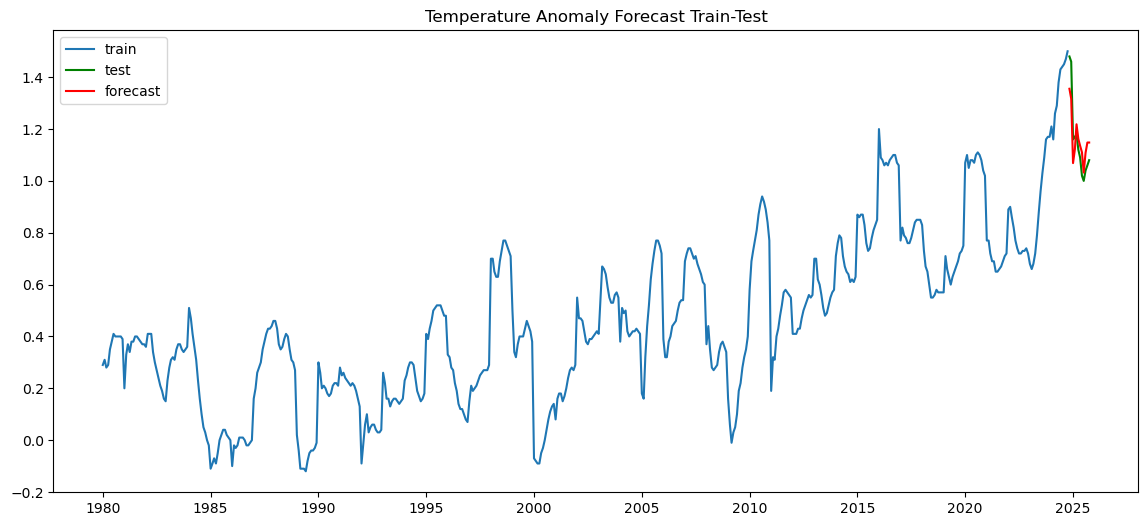

In [44]:
plt.figure(figsize=(14, 6))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test', color='green')
plt.plot(forecast.index, forecast.values, label='forecast', color='red')
plt.title('Temperature Anomaly Forecast Train-Test')
plt.legend()
plt.show()

### Test Forecast Interpretation

The forecasted results of the test set (red line) are very impressive. It almost perfectly aligned the true test values. The XGBoost model was trained using the following parameters:

n_estimators = 100,
max_depth = 3,
learning_rate = 0.05,
subsample = 0.8,
colsample_bytree=0.8,
random_state=42

Evaluation statistics of the XGBoost model are as follows:

- Mean Absolute Error = 0.0733134293556213
- Mean Squared Error =  0.006517235945758524
- Root Mean Squared Error (RMSE) = 0.08072939951317937
- The r2_score  = 0.715714898767349

On average, the model performed very well with MAE=0.073, meaning that the model's predictions are approaximately 0.07 Celsius away from the true values. 
r2 score of 0.72 means that our model's explained 72% of data. 
RMSE of 0.080 means that model's predictions have an error of 0.080 Celsius.

In [53]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

                feature  importance
1             temp_lag2    0.422479
0             temp_lag1    0.341403
2  temp_rolling_mean_4y    0.130939
3   temp_rolling_std_4y    0.044970
5            temp_diff2    0.039961
4            temp_diff1    0.020247
6     years-since-start    0.000000


## Forecasting the future temperature anomalies November 2025 - November 2026



In [ ]:
def create_forecast_features(
    historical_series: pd.Series,
    n_months: int = 12
) -> pd.DataFrame:
    """
    Creates a DataFrame with features for forecasting the next `n_months` months
    using XGBoost with the following features:
      - month (1–12)
      - year
      - lag_12 (value from same month last year)
      - lag_1  (value from previous month)
      - temperature rolling mean 48 months
    
    Parameters:
    -----------
    historical_series : pd.Series
        Time series with DatetimeIndex and temperature anomaly values
        (must have at least 13 months of data)
    
    n_months : int, default 12
        Number of months to forecast into the future
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with index = future dates, columns = ['month', 'year', 'lag_12', 'lag_1']
        Ready to pass directly to model.predict()
    """
    
    if not isinstance(historical_series.index, pd.DatetimeIndex):
        raise ValueError("historical_series must have a DatetimeIndex")
    
    if len(historical_series) < 13:
        raise ValueError("Need at least 13 months of historical data")
    
    # Last observed date
    last_date = historical_series.index[-1]
    
    # Generate future dates (month-start frequency)
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=n_months,
        freq='MS'  # Month Start
    )
    
    # Prepare lag values from historical data
    hist_values = historical_series.values.tolist()
    lag12_values = hist_values[-12:]          # Last 12 months → for lag_12 in next year
    lag1_value   = hist_values[-1]            # Most recent value → first lag_1
    
    features_list = []
    current_lag1 = lag1_value
    
    for i, date in enumerate(future_dates):
        lag12 = lag12_values[i] if i < 12 else np.nan  # After 12 months, lag_12 becomes unknown (optional)
        
        row = {
            'month': date.month,
            'year': date.year,
            'lag_12': lag12,
            'lag_1': current_lag1
        }
        features_list.append(row)
        
        # For recursive forecasting: next month's lag_1 will be this month's prediction
        # (You will fill this in during actual forecasting loop)
        current_lag1 = np.nan  # Will be replaced with prediction in forecasting loop
    
    X_future = pd.DataFrame(features_list, index=future_dates)
    
    return X_future

# Example usage:
if __name__ == "__main__":
    # Example with NASA GISS data
    url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
    df = pd.read_csv(url, skiprows=1)
    df = df.melt(id_vars='Year', value_vars=['Jan','Feb','Mar','Apr','May','Jun',
                                             'Jul','Aug','Sep','Oct','Nov','Dec'],
                 var_name='Month', value_name='Anomaly')
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%b')
    ts = df.set_index('Date')['Anomaly'].sort_index().dropna()
    
    # Create features for next 12 months
    X_forecast = create_forecast_features(ts, n_months=12)
    
    print("Features ready for XGBoost prediction:")
    print(X_forecast[['month', 'year', 'lag_12', 'lag_1']])

In [ ]:
from datetime import datetime
from dateutil import rrule

# Retrain on full dataset
future_xgb = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree=0.8,
    random_state=42
)

#future_features = create_time_features()
X = df_t[feature_cols]
y = df_t['temp_anomaly']
future_xgb.fit(X, y)

# Iteratively forecast future years
future_predictions = []

# dates
start_date = datetime(2025, 11, 1)
end_date = datetime(2026, 11, 1)

for date in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    print(dt)
    # Use previous predictions as features
    X_future = create_features_for_year(year, recent_history)
    prediction = full_model.predict(X_future)[0]
    future_predictions.append(prediction)
    recent_history.append(prediction)
forecast_df = pd.DataFrame({
    'Year': range(2024, 2031),
    'Predicted_CO2': future_predictions
})
print(forecast_df)

## Tuning the XGBoost Hyperparameters using GridSearch

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)